### GPU

In [1]:
import os
os.environ["C`UDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
print("CUDA_DEVICE_ORDER: ", os.getenv("CUDA_DEVICE_ORDER"))
print("CUDA_VISIBLE_DEVICES: ", os.getenv("CUDA_VISIBLE_DEVICES"))

CUDA_DEVICE_ORDER:  None
CUDA_VISIBLE_DEVICES:  0


### IMPORTS

In [2]:
import cv2
import torch
import torchvision
import PIL
from tqdm import tqdm
import numpy as np

In [3]:
#from sklearn.metrics import mean_squared_error
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt

In [4]:
from autopilot_dataset import AutopilotDataset
from autopilot_model import AutopilotModel
from autopilot_utils import preprocess_image
print("All modules have been successfully imported.")

All modules have been successfully imported.


<br>

### HYPERPARAMETERS

In [5]:
BATCH_SIZE = 32
MAX_EPOCHS = 40
EARLY_STOPPING_PATIENCE = 4

INITIAL_LR = 0.0001
LR_REDUCER_PATIENCE = 2
LR_REDUCER_FACTOR = 0.8

ACCEPTABLE_TESTING_LOSS = 0.05

FRAME_SIZE = 224

MODELS_DIR = "/home/jetson/models/jetson/"
DATASETS_DIR = "/home/jetson/datasets/"

VERSION = "lintasan_surma"

MODEL_PATH = MODELS_DIR + VERSION + "_resnet18" + ".pth"
TRAINING_DATASET = DATASETS_DIR + "training_surma/"
VALIDATION_DATASET = DATASETS_DIR + "validation_surma/"
TESTING_DATASET = DATASETS_DIR + "testing_surma/"

<br>

### DATA

In [6]:
training_dataset = AutopilotDataset(TRAINING_DATASET,
                                    FRAME_SIZE,
                                    random_horizontal_flip=True,
                                    random_noise=True,
                                    random_blur=True,
                                    random_color_jitter=True,
                                    keep_images_in_ram=True)
training_loader = torch.utils.data.DataLoader(training_dataset,
                                              batch_size=BATCH_SIZE,
                                              shuffle=True)

validation_dataset = AutopilotDataset(VALIDATION_DATASET,
                                      FRAME_SIZE,
                                      random_horizontal_flip=False,
                                      random_noise=False,
                                      random_blur=False,
                                      random_color_jitter=False,
                                      keep_images_in_ram=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset,
                                                batch_size=BATCH_SIZE,
                                                shuffle=True)

testing_dataset = AutopilotDataset(TESTING_DATASET,
                                   FRAME_SIZE,
                                   random_horizontal_flip=False,
                                   random_noise=False,
                                   random_blur=False,
                                   random_color_jitter=False,
                                   keep_images_in_ram=True)
testing_loader = torch.utils.data.DataLoader(testing_dataset,
                                                batch_size=1,
                                                shuffle=False)

Generated dataset of 4121 items
Generated dataset of 515 items
Generated dataset of 516 items


<br>

### MODEL

In [7]:
model = AutopilotModel(pretrained=True)
for param in model.network.parameters():
    param.requires_grad = True
optimizer = torch.optim.Adam(model.parameters(), lr=INITIAL_LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       'min',
                                                       patience=LR_REDUCER_PATIENCE,
                                                       factor=LR_REDUCER_FACTOR,
                                                       verbose=True)  
loss_function = torch.nn.MSELoss()

<br>

### TRAINING

Validation Epoch 0: 100%|██████████| 17/17 [00:22<00:00,  1.31s/batch]


validation loss decreased to 0.07622086585444562, saving model


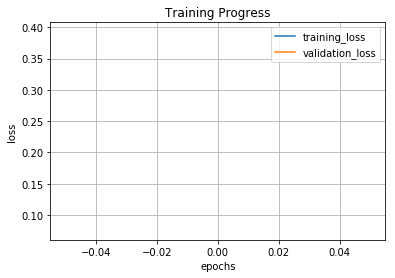

Validation Epoch 1: 100%|██████████| 17/17 [00:23<00:00,  1.37s/batch]


validation loss decreased to 0.053484751349862886, saving model


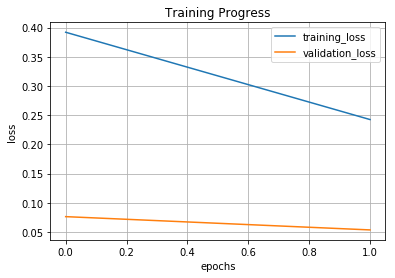

Validation Epoch 2: 100%|██████████| 17/17 [00:22<00:00,  1.34s/batch]


validation loss decreased to 0.041578317499336076, saving model


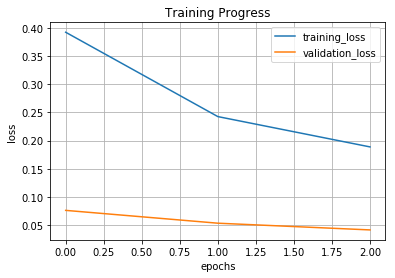

Validation Epoch 3: 100%|██████████| 17/17 [00:17<00:00,  1.00s/batch]


validation loss decreased to 0.04008143132223802, saving model


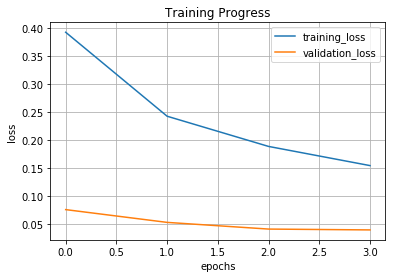

Validation Epoch 4: 100%|██████████| 17/17 [00:19<00:00,  1.14s/batch]


validation loss decreased to 0.03855962788357454, saving model


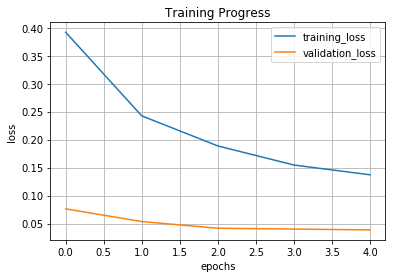

Validation Epoch 5: 100%|██████████| 17/17 [00:16<00:00,  1.04batch/s]


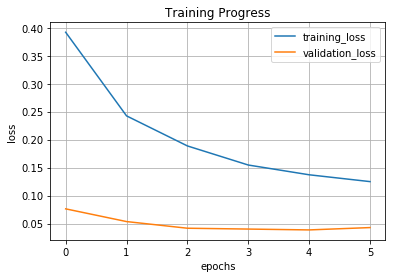

Validation Epoch 6: 100%|██████████| 17/17 [00:13<00:00,  1.25batch/s]


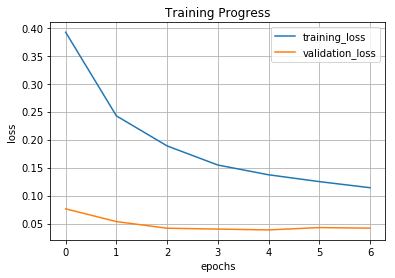

Validation Epoch 7: 100%|██████████| 17/17 [00:15<00:00,  1.12batch/s]


validation loss decreased to 0.02490089158527553, saving model


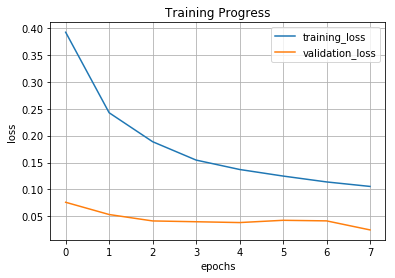

Validation Epoch 8: 100%|██████████| 17/17 [00:13<00:00,  1.23batch/s]


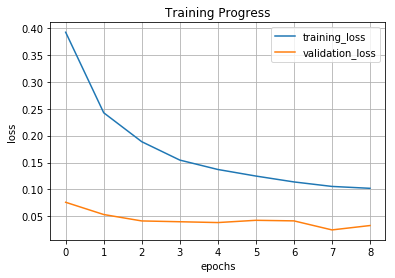

Validation Epoch 9: 100%|██████████| 17/17 [00:16<00:00,  1.03batch/s]


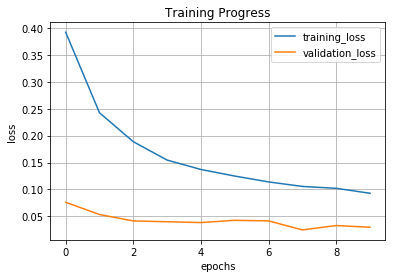

Validation Epoch 10: 100%|██████████| 17/17 [00:14<00:00,  1.18batch/s]


validation loss decreased to 0.02384938674924128, saving model


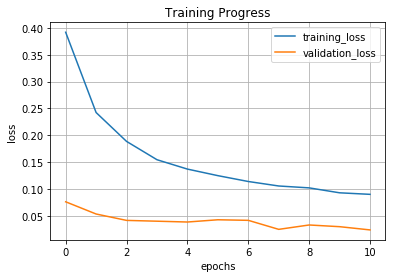

Validation Epoch 11: 100%|██████████| 17/17 [00:10<00:00,  1.55batch/s]


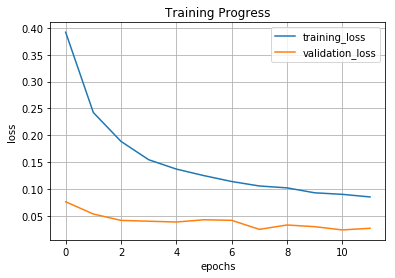

Validation Epoch 12: 100%|██████████| 17/17 [00:15<00:00,  1.07batch/s]


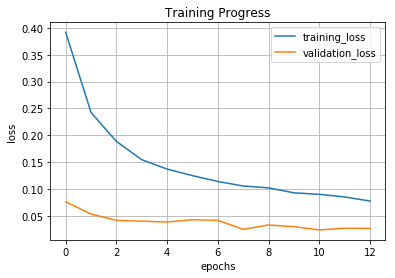

Validation Epoch 13: 100%|██████████| 17/17 [00:13<00:00,  1.28batch/s]


Epoch    14: reducing learning rate of group 0 to 8.0000e-05.


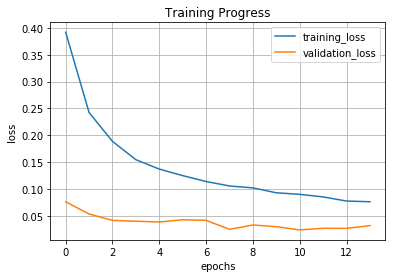

Validation Epoch 14: 100%|██████████| 17/17 [00:19<00:00,  1.17s/batch]


validation loss of 0.02384938674924128 hasn't improved in last 4 epochs, stopping training


In [8]:
training_losses = []
validation_losses = []
epochs_without_improvement = 0

def plot_losses():
    fig, ax = plt.subplots()
    ax.plot([x for x in range(len(training_losses))], training_losses, label='training_loss')
    ax.plot([x for x in range(len(validation_losses))], validation_losses, label='validation_loss')
    ax.set(xlabel='epochs', ylabel='loss', title='Training Progress')
    ax.grid()
    plt.legend()
    plt.show()
    
def run_epoch(tepoch, name, training):
    epoch_loss = 0.0
    iterations = 0
    
    for _, images, annotations in tepoch:
        tepoch.set_description(f"{name} Epoch {epoch}")

        images = images.cuda()
        annotations = annotations.cuda()
        
        if training:
            optimizer.zero_grad()
            model.train()
            outputs = model(images)
        else:
            with torch.no_grad():
                model.eval()
                outputs = model(images)
        
        loss = loss_function(outputs, annotations)
        
        if training:
            loss.backward()
            optimizer.step()

        epoch_loss += loss.item()
        iterations += 1
        
    return float(epoch_loss/iterations)

for epoch in range(MAX_EPOCHS):
    with tqdm(training_loader, unit="batch") as training_epoch:
        avg_training_loss = run_epoch(training_epoch, "Training", training=True)
        training_losses.append(avg_training_loss)
    
    with tqdm(validation_loader, unit="batch") as validation_epoch:
        avg_validation_loss = run_epoch(validation_epoch, "Validation", training=False)
        scheduler.step(avg_validation_loss)
        validation_losses.append(avg_validation_loss)
        
        if avg_validation_loss <= np.min(validation_losses):
            epochs_without_improvement = 0
            print("validation loss decreased to " + str(avg_validation_loss) + ", saving model")
            model.save_to_path(MODEL_PATH)
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= EARLY_STOPPING_PATIENCE:
                print("validation loss of " + str(np.min(validation_losses)) + " hasn't improved in last " + str(EARLY_STOPPING_PATIENCE) + " epochs, stopping training")
                break
        
    plot_losses()

<br>

### TESTING

In [ ]:
model.load_from_path(MODEL_PATH)

results = []
losses = []
with torch.no_grad():
    model.eval()
    
    for name, image, annotation in testing_loader:
        prediction = model(image.cuda()).clamp(min=-1, max=1)
        loss = round(float(loss_function(prediction, annotation.cuda()).cpu()), 4)
        passed = loss < ACCEPTABLE_TESTING_LOSS
        losses.append(loss)
        results.append(passed)
               
        composed_transforms = torchvision.transforms.Compose([
            torchvision.transforms.Normalize([-0.485/0.229, -0.456/0.224, -0.406/0.225], [1/0.229, 1/0.224, 1/0.225]),
            torchvision.transforms.ToPILImage()
        ])
        image = composed_transforms(image[0])
        image = image.convert("RGB")
        display(image)
        
        print(name[0])
        print("expected: "+str(annotation.float()[0]))
        print("predicted: "+str(prediction.cpu().float()[0]))
        print("loss: "+str(loss))
        print("passed: "+str(passed))
        print("")

print("SCORE: "+str(len([x for x in results if x]))+"/"+str(len(results))+", AVG LOSS: "+str(round(np.mean(losses), 4)))    